# Xarray Basics

This notebook demonstrates some of the basic xarray functionality.

Open an interactive notebook:

1. Sign into the SHIFT SMCE Daskhub and select an instance size in different tab

2. Follow this [link](https://daskhub.shift.mysmce.com/user/joyvan/pasarela/open?url=https://raw.githubusercontent.com/EvanDLang/SHIFT-SMCE-User-Guide/development/docs/source/notebooks/xarray_basics.ipynb)

3. Select the "notebook" kernel

## Streamlined Xarray Interface to AVIRIS Datasets

We have an experimental capability to access the entire set of AVIRIS gridded mosaics as a single Xarray dataset (that can be subset by space, time, and wavelength). To open the dataset, code like the following (pay careful attention to the open_dataset arguments, position of brackets, quotes, etc.)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

dat = xr.open_dataset("reference://", engine="zarr", backend_kwargs={
    "consolidated": False,
    "storage_options": {"fo": "s3://dh-shift-curated/aviris/v1/gridded/zarr.json"}
})

### Select a pixel at a time step and plot the reflectance

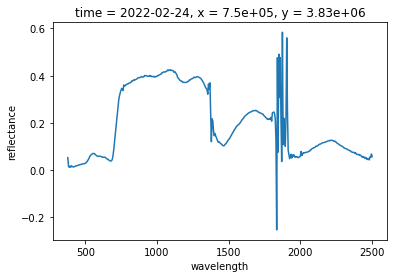

In [2]:
dsub = dat.sel(x=750_000, y=3_830_000, time="2022-02-24", method="nearest")
dsub.reflectance.plot()

### Extract a time series for a pixel

In [3]:
dsub = dat.sel(x=750_000, y=3_830_000, method="nearest").reflectance

fig, ax = plt.subplots()
plt.ylabel("reflectance")
plt.xlabel("wavelength")

x = dsub[0].wavelength
line, = ax.plot(x, dsub[0])
ax.set_title(str(pd.Timestamp(dsub.time[0].item())))

def animate(i):
    line.set_ydata(dsub[i])  # update the data
    ax.set_title(str(pd.Timestamp(dsub.time[i].item())))
    return line,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(dsub), interval=1000)


plt.close()
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

### Select multiple adjacent pixels at a particular time

In [4]:
dsub = dat.sel(x=750_000, time="2022-02-24", method="nearest").drop("x").sel(y=slice(3_830_020, 3_830_000)).reflectance

fig, ax = plt.subplots()
plt.ylabel("reflectance")
plt.xlabel("wavelength")

x = dsub[0].wavelength
line, = ax.plot(x, dsub[0])
ax.set_title(str(dsub.y[0].item()))

def animate(i):
    line.set_ydata(dsub[i])  # update the data
    ax.set_title("x:750000 y: " + str(dsub.y[i].item()))
    return line,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(dsub), interval=1000)

plt.close()
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

### Calculate a vegetation index through time for an area

In [5]:
# Slice an area using x, y, and time
aoi = dat.sel(x=slice(730300,731000), y=slice(3819660,3819050), time="2022-03-08")

# Reshape to increase computational speed
aoi = aoi.stack(combined=('y', 'x'))

# Calculate NDVI
red = aoi.sel(wavelength=660, method="nearest").reflectance
nir = aoi.sel(wavelength=880, method="nearest").reflectance
ndvi = (nir - red) / (nir + red)

# Return to the orginal shape
ndvi = ndvi.unstack('combined')

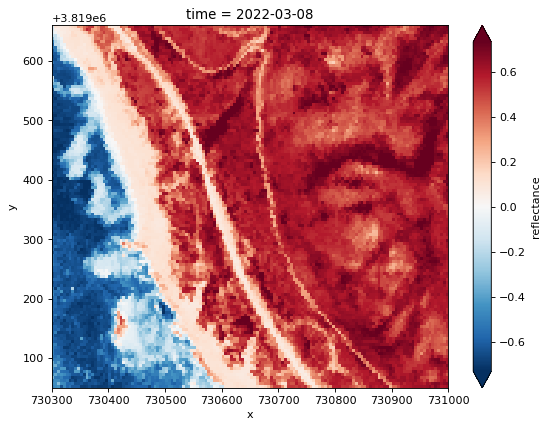

In [6]:
# Plot
plt.figure(figsize=(8, 6), dpi=80)
ndvi.plot.pcolormesh("x", "y", robust=True, add_colorbar=True);